[![Segmentation](https://github.com/ttompk/musings/blob/master/images/t-dist.png?raw=true "Troy's Github")](https://github.com/ttompk/uscf_grinberg_neuro_images/tree/troy) ![Troy](https://github.com/ttompk/musings/blob/master/images/seg.png?raw=true)

# UCSF Neuron Segmentation - Fastai for Image Segmentation
---

[Today's Date]  
Written in python: 3.7.4

In [1]:
from platform import python_version
print('Your python version: {}'.format(python_version()))

Your python version: 3.7.3


### To Dos:

- split images into equal pieces for training (500x500?)
- no metrics (ex. accuracy) on the validation set at this point. I believe this is due to training images and validation image being different sizes. Currently throws a pytorch error if metric included. 
- when we overlay the training masks on the images - one image appears green while the other is blue - is that a problem???


## Notebook TOC
---
1. Overview
2. Libraries
3. Generalized Functions
4. Data ETL
5. Analysis
6. Conclussion
7. Next Steps

## 1. Overview
---
This notebook was developed for image sementation using the Fastai library. Segmentation is predicting the class of each pixel in an image.

### Directive/Objective
Identify NeuN stained neurons in microscopy slides and measure amount of co-localization with other staining markers (different channels than NeuN). 

**Part 1**  
Segmentation. Identify the NeuN-stained neurons using the fastai library.

**Part 2**  
Perform co-localization of the neurons with other channels. Obtain location of neuron segmentation (perhaps return colormap). 

**Part 3**  
Package the tool for use in ImageJ - either as a plug-in or other method (see ImageJ developer tools). Will require tool to be validated on several image sizes.


### Data Source
Each image in the 'images' subfolder has an equivalent in 'labels'. The 'labels' are the expertly labeled segmentation masks. 

This is the link to the GCP 'storage' folder. [link to data]()

## 2. Libraries
---

In [2]:
# basic kit - included in default anaconda env list
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from pathlib import Path
#import pandas_profiling
import re
import collections

In [3]:
from fastai.vision import *
from PIL import Image as pil_image
from src.img_functions import *

In [4]:
%load_ext autoreload
%autoreload 2

## 3. Generalized Functions
---

In [5]:
# functions moved to img_functions.py

## 4. Data
---

### 4.1 Define classification classes
Class names are stored in a text file.

In [6]:
# load the class definitions
codes = np.loadtxt('data/codes.txt', dtype=str)    # these are the classes
pd.DataFrame(codes)

,0
0,background
1,neuron


### 4.2 Training images

In [7]:
# images
#path_img = Path('data/images')   # images go here
path_img = Path('data/images_beta')   # images go here
img_names = get_image_files(path_img)  # a list of posixpath filenames

There are 3 image files.
First 3 image files:
0:	Name: data/images_beta/TrainingData_1_original.tif
	Shape: torch.Size([3, 3032, 3012])

1:	Name: data/images_beta/TrainingData_4_original.tif
	Shape: torch.Size([3, 640, 918])

2:	Name: data/images_beta/TrainingData_3_original.tif
	Shape: torch.Size([3, 3012, 2500])



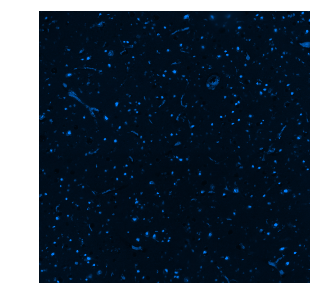

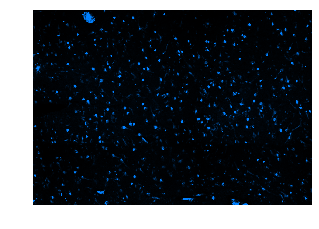

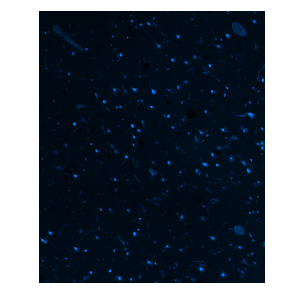

In [8]:
# Print out info on the training images.
train_img_test(img_names, open_image)

### 4.3 Image masks...aka labels

In [9]:
# This function maps each image filename with corresponding mask filename.
# This function gets called when we define a 'data' object for training/validation.
# Label mask file names are same as training image filenames with addition of '_P' at the end.
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'    # only works wth PosixPath object

There are 3 images in the folder.
First 3 image files:
---------------------
0
Name: data/images_beta/TrainingData_1_original.tif
Size: Train - [3032 3012] 	Mask - [3032 3016]
Unique Color Classes:[0 1]
tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 1, 0, 0]]])
---------------------
1
Name: data/images_beta/TrainingData_4_original.tif
Size: Train - [640 918] 	Mask - [640 918]
Unique Color Classes:[0 1]
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
---------------------
2
Name: data/images_beta/TrainingData_3_original.tif
Size: Train - [3012 2500] 	Mask - [3012 2500]
Unique Color Classes:[0 1]
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,

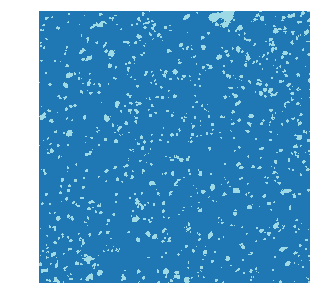

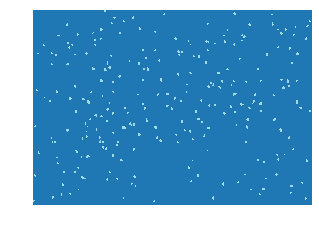

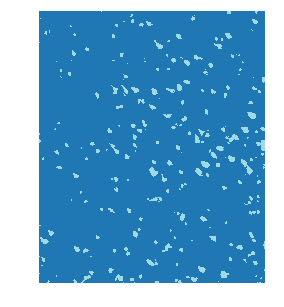

In [10]:
# load label images
#path_lbl = Path('data/labels_int', )   # labels go here
path_lbl = Path('data/labels_int_beta', )   # labels go here
lbl_names = get_image_files(path_lbl)   # a list of posixpath filenames
label_info(img_names, lbl_names, get_y_fn)   # overview of training imgaes and masks

In [11]:
# display image in another window
img_window(img_names[0])

#### 4.2 Define data object

[spliting training data into train/validation](https://docs.fast.ai/vision.data.html)


if CUDA error on JPG image load...then the tensor generated from the mask (ground truth map) 
may return values greater the number of classes. Example, 0.0001 and 0.000001 need to both be 0.
This code is intended to override the fastai 'open' method and processes the data as 0 or 1. Code 
needs to be optimized for current variables.

`from fastai.vision.image import open_image, pil2tensor, ImageSegment
class CustomSegmentationList(SegmentationItemList):
    def open(self, fn):
        x = open_image(fn, div=False).data
        x = pil2tensor(x, np.float32)
        return ImageSegment(x/x.max())
`

#### 4.2.1 Transform the data

In [12]:
# set transformations to training images
# flip_vert=True: randomly flip images horizontally and vertically
# max_warp=0.:  warping allows for chanfe on perspective. To not use, set to 0. <- set to zero for satellites too

tfms = get_transforms(flip_vert=True, max_warp=0.)   

#### 4.2.2 Size data for modeling

In [14]:
train_img_size = 1024

In [15]:
# load image data from folder
data = (SegmentationItemList.from_folder(path_img)   # load the data from a folder
        #.split_by_rand_pct()   # split data into training and validaiton sets by random percent
        .split_by_fname_file('../valid.txt')   # split data by folder if text file present
        #.split_none()     # if no validation data
        #.label_from_func(get_y_fn, classes=codes, convert_mode='L')  # label data using 'get_y_fn' function
        .label_from_func(get_y_fn, classes=codes)  # label data using 'get_y_fn' function
        .transform(tfms, tfm_y=True, size=train_img_size)  # flip image horizontally, we need to use tfm_y=True in the transform call because we need the same transforms to be applied to the target mask as were applied to the image
        .databunch(bs=2, path=Path('data'))  # create a databunch, 'bs' = batch size, 
        .normalize(imagenet_stats))  # normalize for resnet

In [17]:
# verify the data is as expected
data

ImageDataBunch;

Train: LabelList (2 items)
x: SegmentationItemList
Image (3, 1024, 1024),Image (3, 1024, 1024)
y: SegmentationLabelList
ImageSegment (1, 1024, 1024),ImageSegment (1, 1024, 1024)
Path: data/images_beta;

Valid: LabelList (1 items)
x: SegmentationItemList
Image (3, 1024, 1024)
y: SegmentationLabelList
ImageSegment (1, 1024, 1024)
Path: data/images_beta;

Test: None

In [18]:
# returns training image and label size
print(data.train_ds[0])
print("Classes: {}".format(data.valid_ds.classes))

(Image (3, 1024, 1024), ImageSegment (1, 1024, 1024))
Classes: ['background' 'neuron']


Overlay of masks on training images


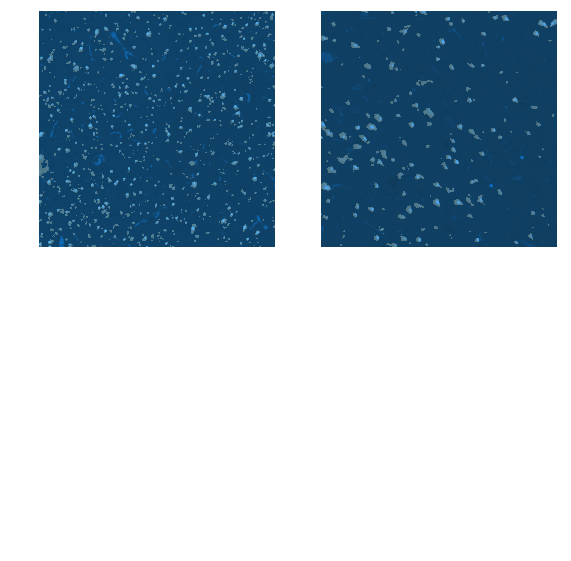

In [19]:
# do the masks align with the base image??
print("Overlay of masks on training images")
data.show_batch(rows=2, figsize=(8,8))

## 5. Training
---

#### **5.1. Model**

Choosing the model architecture.  

The model architecture can be provided using fastai syntax. Example:
- `model = simple_cnn((3,16,16,2))`  builds a cnn model with a binary output with following layers: 

The fastai library includes several pretrained models from torchvision, namely:
- resnet18, resnet34, resnet50, resnet101, resnet152
- squeezenet1_0, squeezenet1_1
- densenet121, densenet169, densenet201, densenet161
- vgg16_bn, vgg19_bn
- alexnet  

On top of the models offered by torchvision, fastai has implementations for the following models:

- Darknet architecture, which is the base of [Yolo v3](https://pjreddie.com/media/files/papers/YOLOv3.pdf)
- Unet architecture based on a pretrained model. The original unet is described [here](https://arxiv.org/abs/1505.04597), the model implementation is detailed in [models.unet](https://docs.fast.ai/vision.models.unet.html#vision.models.unet)
- Wide resnets architectures, as introduced in [this article](https://arxiv.org/abs/1605.07146)

In [20]:
# assign the model (pretrained or not)

model = models.resnet18  
#model = models.unet  # check this syntax.  
#model = simple_cnn((3,16,16,2))  

#### **5.2. Optimization Function**

Choose the optimization function. Options include:
- 'Adam'

Really Adam is the only one to use (for now). Fastai implementation uses decoupled weight regularization - don't know if this is true in pytorch. Adam combines elements of momentum with ....[ref](https://arxiv.org/abs/1711.05101)

In [21]:
opt_func = 'Adam'

#### **5.3. Loss Function**

Choose the loss function. Fastai defaults to None.

In [22]:
loss_func = None

#### **5.4. Learner**

Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`.

`Learner (data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None, metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None, cb_fns_registered:bool=False)`

In [37]:
#learn = Learner(data, model)
#learn = cnn_learner(data, model)
#learn = unet_learner(data, model, opt_func=opt_func)  # not working
learn = unet_learner(data, model)
#learn = Learner.create_unet(data, model)   # not sure this works

#### 5.4.1. Metrics

In [33]:
# Metrics
# metrics always calculated on the validation set
# custom metric function (if needed):
def acc_custom(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

#learn.metrics=acc_custom    # accuracy does not work on multilabel classification - the above metric doesn't work - images wrong sizes

#learn.metrics=accuracy   # does not work.

#### 5.4.2. Callbacks

In [25]:
# Callbacks to modify training
#cb = OneCycleScheduler(learn, lr_max=0.01)   # this function not working - not needed at the moment - revisit

In [26]:
# display the model architecture - summary has more info - very long print out!
#learn.model      # just the model
#learn.summary    # model and data info

### 5.5. Learning Rate Finder

The learning rate finder function is performed each time the model architecture is changed. Will perform a learning rate search step-wise through a range. 

Other strategies for hyperparameter optimization include:   
Uninformed
- grid search (worst, uninformed)
- random search  (better, uninformed)  

Bayesian optimization (sequential model-based optimization)
- gaussian processes
- random forest regression
- Tree of Parzen Estimators (TPE) (hyperopt) [ref](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)


Bayesian optimization, also called Sequential Model-Based Optimization (SMBO), implements this idea by building a probability model of the objective function that maps input values to a probability of a loss: p (loss | input values). The probability model, also called the surrogate or response surface, is easier to optimize than the actual objective function. Bayesian methods select the next values to evaluate by applying a criteria (usually Expected Improvement) to the surrogate. The concept is to limit evals of the objective function by spending more time choosing the next values to try.


`lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)`

wd:  weight decay. Use wd = 0.1 as a good starting point. "let’s not just add the sum of the squares of the parameters to the model but let’s multiply that by some number that we choose. And that number that we choose in fast is called wd"

In [27]:
# run learning rate finder
learn.lr_find(start_lr=1e-07, wd=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


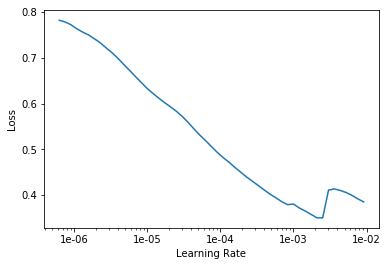

In [28]:
# plot the finder results
learn.recorder.plot()

In [29]:
# set the learning rate to be used in fitting the model.
lr = 1e-3

#### **5.6. Fit**

`fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Point=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Optional[Collection[Callback]]=None, tot_epochs:int=None, start_epoch:int=None)`

In [30]:
#learn.data.single_ds.tfmargs['size'] = None 

In [38]:
#n_epochs = 3
#learn.fit(epochs=n_epochs, callbacks=cb)
learn.fit_one_cycle(cyc_len=10, max_lr=slice(lr))    # normaly set 'cyc_len'=3
#learn.save('mini_train')   # this saves to the 'data' dir under a dir labeled 'models' (under .fastai if not local)

epoch,train_loss,valid_loss,time
0,1.408778,0.544067,00:04
1,1.006594,0.304942,00:04
2,1.083643,0.093098,00:04
3,0.860572,1.148889,00:04
4,1.310245,0.074306,00:04
5,1.127918,0.071308,00:04
6,1.012118,0.066238,00:04
7,0.916912,0.059988,00:04
8,0.839357,0.056235,00:04
9,0.775838,0.055007,00:04


#### 6. Show Results
---

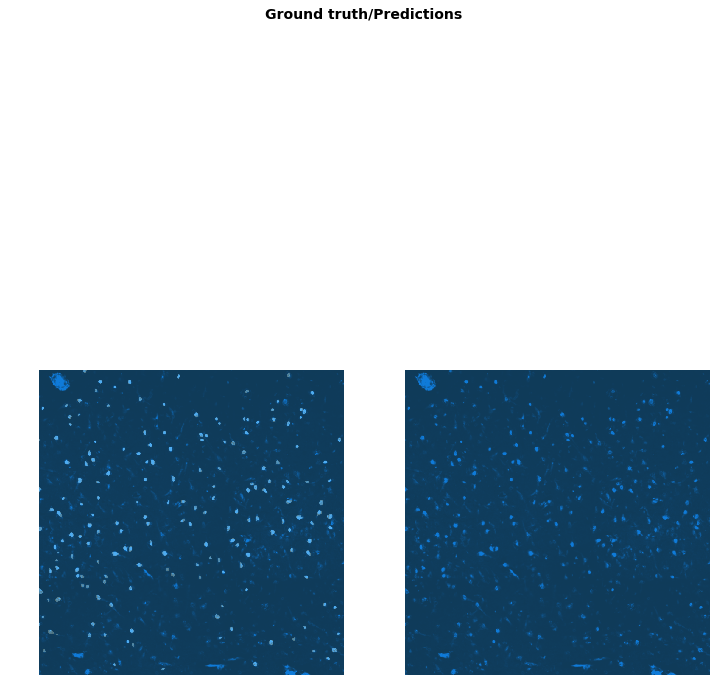

In [39]:
#learn.show_results()
learn.show_results(rows=1, figsize=(12,15))

## 7. Next Steps
---

Image location - where are the predicted pixels located?